In [ ]:
!pip install torch spacy nlpaug nltk tensorflow sacremoses gensim seaborn matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 26.3 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import re
import spacy
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk

nltk.download('stopwords')
nltk.download('wordnet')


spacy.prefer_gpu()  # Or spacy.require_gpu() if mandatory
# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('Tweets.csv')

# Display the first few rows of the dataset
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer # import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() # instantiate WordNetLemmatizer

def clean_text(text):
    # Check if text is a string
    if isinstance(text, str):
        # Lowercasing
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user @ references and '#' from hashtags
        text = re.sub(r'\@\w+|\#','', text)
        # Remove punctuation and non-alphabetic characters
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Lemmatization and stopword removal
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        # Join tokens back into a single string
        return " ".join(tokens)
    else:
        # Return empty string for non-string values
        return ""

# Function for lemmatization and stopwords removal
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if token.text not in stop_words])
    return lemmatized

# Apply the preprocessing
df['clean_text'] = df['text'].apply(clean_text)
df['processed_text'] = df['clean_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.to_csv('preprocessed_Tweets.csv', index=False)

In [ ]:
print(df)

           textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  \
0                    I`d have responded, if I were going   neutra

In [ ]:
# Count the total number of rows in the 'processed_text' column
total_rows = df['processed_text'].shape[0]

# Count the number of non-empty, non-NaN values in the 'processed_text' column
non_empty_rows = df['processed_text'].dropna().apply(lambda x: isinstance(x, str) and x.strip() != '').shape[0]

print(f"Total rows in 'processed_text': {total_rows}")
print(f"Non-empty and valid rows in 'processed_text': {non_empty_rows}")


Total rows in 'processed_text': 27481
Non-empty and valid rows in 'processed_text': 27481


In [10]:
import torch
import nlpaug.augmenter.word as naw
import pandas as pd
from transformers import pipeline
# Move the models to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use batch translation to speed up the process
# Initialize the back-translation augmenter
aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en',
    device=device  # Specify GPU
)


# Apply back-translation in batches for faster processing
def batch_back_translate(texts, batch_size=32):
    """Back-translate texts in batches to improve performance."""
    augmented_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        # Augment the batch
        augmented_batch = aug.augment(batch)
        augmented_texts.extend(augmented_batch)
    return augmented_texts

# Check if text is valid and not NaN
valid_texts = df['clean_text'].apply(lambda x: isinstance(x, str) and not pd.isna(x))

# Apply back translation in batches
df.loc[valid_texts, 'back_translated_text'] = batch_back_translate(df.loc[valid_texts, 'clean_text'].tolist())

# Display original and augmented text
df[['clean_text', 'back_translated_text']].head()

# Save the augmented dataset
df.to_csv('Tweets_with_back_translation_orginal.csv', index=False)
print(df['clean_text'].shape[0])


27481


In [11]:
# Install necessary libraries (run in your Colab environment)
# !pip install --upgrade nlpaug transformers

import torch
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import pandas as pd

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Augmentation: Synonym Replacement using BERT (contextual word embeddings)
synonym_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device=device)


# Example of augmenting a sentence using synonym replacement
df['augmented_text'] = df['processed_text'].apply(
    lambda x: synonym_aug.augment(x) if isinstance(x, str) and not pd.isna(x) else x
)

# Display augmented texts
df[['processed_text', 'augmented_text']].head()


# Display the augmented and back-translated text
df[['processed_text', 'augmented_text', 'back_translated_text']].head()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

,processed_text,augmented_text,back_translated_text
0,respond go,[respond ।],
1,sooo sad miss san diego,[sooo as miss san ma],sooo sad Miss san diego
2,bos bully,[... bully],Bullying
3,interview leave alone,[to leave alone],Leave the interview alone
4,son could not put release already buy,[she could not pull out already buy],Son could not secure release


In [ ]:
#didnt run the below code;
#!pip install --upgrade nlpaug transformers
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas # The nas module should now contain BackTranslationAug

# # Augmentation: Synonym Replacement using Word2Vec/BERT
# synonym_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

# # Augmentation: Back Translation using NLPAug
# back_translation_aug = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de', to_model_name='facebook/wmt19-de-en')
# # Example of augmenting a sentence using synonym replacement
# df['augmented_text'] = df['processed_text'].apply(lambda x: synonym_aug.augment(x) if isinstance(x, str) and not pd.isna(x) else x)

# # Example of augm
# # Display augmented texts
# df[['processed_text', 'augmented_text', 'back_translated_text']].head()

In [12]:
import pandas as pd
import nlpaug.augmenter.word as naw
import random
from nltk.corpus import wordnet
import nltk
print(df.columns)
# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
swap_aug = naw.RandomWordAug(action="swap")
delete_aug = naw.RandomWordAug(action="delete")

# Function for synonym replacement using WordNet
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random.shuffle(words)
    num_replaced = 0
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if w == word and num_replaced < n else w for w in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Text augmentation pipeline
# Text augmentation pipeline
def augment_text(text, num_augmentations=3):
    # Check if text is valid
    if isinstance(text, str) and len(text) > 0:
        augmented_texts = []

        for _ in range(num_augmentations):
            aug_choice = random.choice(['synonym', 'swap', 'delete'])

            if aug_choice == 'synonym':
                augmented_text = synonym_aug.augment(text)
            elif aug_choice == 'swap':
                augmented_text = swap_aug.augment(text)
            elif aug_choice == 'delete':
                augmented_text = delete_aug.augment(text)
            else:
                augmented_text = text

            augmented_texts.append(augmented_text)

        return augmented_texts
    else:
        return text # Return original text if not valid

# Apply augmentation to the 'cleaned_text' column
df['augmented_texts'] = df['clean_text'].apply(lambda x: augment_text(x, num_augmentations=3))
# Save the augmented dataset to a new CSV file
df.to_csv('augmented_Tweets.csv', index=False)

print("Text augmentation applied and saved to 'augmented_Tweets.csv'.")


Index(['textID', 'text', 'selected_text', 'sentiment', 'clean_text',
       'processed_text', 'back_translated_text', 'augmented_text'],
      dtype='object')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Text augmentation applied and saved to 'augmented_Tweets.csv'.


In [13]:
import ast
import pandas as pd

# Step 1: Create separate DataFrames for each text column
processed_text_df = df[['processed_text', 'sentiment']].rename(columns={'processed_text': 'text'})
back_translated_text_df = df[['back_translated_text', 'sentiment']].rename(columns={'back_translated_text': 'text'})
augmented_text_df = df[['augmented_text', 'sentiment']].rename(columns={'augmented_text': 'text'})


# Function to safely parse stringified lists with error handling
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return []  # Return an empty list if parsing fails

# Flatten the 'augmented_texts' column and create a DataFrame for the augmented texts
augmented_df = pd.DataFrame({
    'text': [item for sublist in df['augmented_texts'].apply(safe_literal_eval) for item in sublist if item],  # Flatten and filter out empty items
    'sentiment': df.loc[df.index.repeat(df['augmented_texts'].apply(lambda x: len(safe_literal_eval(x)))), 'sentiment'].values
})


# Combine original clean_text with the augmented texts
original_df = df[['clean_text', 'sentiment']].rename(columns={'clean_text': 'text'})

# Concatenate the original and augmented texts into one DataFrame
combined_df = pd.concat([original_df, augmented_df, processed_text_df, back_translated_text_df, augmented_text_df], ignore_index=True)

# Reset the index to avoid issues with concatenation
combined_df.reset_index(drop=True, inplace=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_augmented_tweetsfinal.csv', index=False)
# print(combined_df.head())

print("Combined augmented data saved to 'combined_augmented_tweetsfinal.csv'")


Combined augmented data saved to 'combined_augmented_tweetsfinal.csv'


In [14]:
combined_df=pd.read_csv('combined_augmented_tweetsfinal.csv')

In [15]:
# Find duplicate rows in the 'text' column (considering 'text' only for duplicates)
duplicates = combined_df[combined_df.duplicated(subset=['text'], keep=False)]

# Count the number of duplicates
num_duplicates = duplicates.shape[0]

# Display the count of duplicate rows
print(f"Number of duplicate rows based on 'text' column: {num_duplicates}")

# If you want to see the duplicated rows:
print(duplicates)

# Optional: Save the duplicate rows to a CSV file for further inspection
duplicates.to_csv('duplicate_texts.csv', index=False)


Number of duplicate rows based on 'text' column: 36148
                                                   text sentiment
1                               sooo sad miss san diego  negative
3                                 interview leave alone  negative
7                                            soooo high   neutral
8                                                   NaN   neutral
11      really really like song love story taylor swift  positive
...                                                 ...       ...
192051                                      ['[UNK] ।']   neutral
192065                                  ['the outside']   neutral
192067                                          ['off']   neutral
192108                                        ['it is']   neutral
192155                                            ['a']  positive

[36148 rows x 2 columns]


In [16]:
import re

# Function to preprocess text (lowercase, punctuation removal, etc.)
def preprocess_text(text):
    # Check if text is valid
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters, punctuation, and symbols like [' and others
        text = re.sub(r"[^a-zA-Z\s]", '', text)  # Only keep alphabetic characters and spaces

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    else:
        return "" # Return an empty string if text is not valid

# Apply preprocessing to the 'text' column
combined_df['text'] = combined_df['text'].apply(preprocess_text)

# Remove duplicate rows based on the 'text' column
combined_df.drop_duplicates(subset='text', inplace=True)

# Reset the index after removing duplicates
combined_df.reset_index(drop=True, inplace=True)

# Save the preprocessed dataset to a new CSV file
combined_df.to_csv('preprocessed_combined_datasetfinal.csv', index=False)

# Display the first few rows of the preprocessed dataframe
# Display the first few rows of the preprocessed dataframe
combined_df.head()
# The ace_tools module is not recognized, so using the head() method to display the DataFrame instead

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


In [18]:

duplicates = combined_df[combined_df.duplicated(subset=['text'], keep=False)]

# Count the number of duplicates
num_duplicates = duplicates.shape[0]

# Display the count of duplicate rows
print(f"Number of duplicate rows based on 'text' column: {num_duplicates}")

# If you want to see the duplicated rows:
print(duplicates)

Number of duplicate rows based on 'text' column: 0
Empty DataFrame
Columns: [text, sentiment]
Index: []


In [19]:

# Calculate text lengths
combined_df['text_length'] = combined_df['text'].str.len()

# Get the range of text lengths
min_length = combined_df['text_length'].min()
max_length = combined_df['text_length'].max()

print(f"Minimum text length: {min_length}")
print(f"Maximum text length: {max_length}")

# You can also explore the distribution of text lengths using histograms or other visualizations
# import matplotlib.pyplot as plt
# plt.hist(combined_df['text_length'])
# plt.xlabel('Text Length')
# plt.ylabel('Frequency')
# plt.show()


Minimum text length: 0
Maximum text length: 897


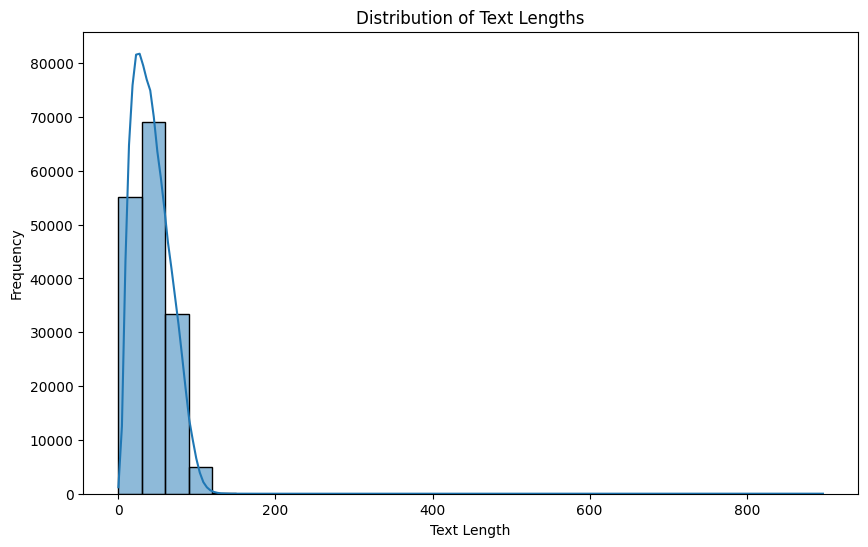

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [23]:

# Count the number of rows with text length equal to 0
zero_length_count = combined_df[combined_df['text_length'] == 0].shape[0]

# Count the number of rows with text length greater than 150
greater_than_150_length_count = combined_df[combined_df['text_length'] > 150].shape[0]

print(f"Number of rows with text length equal to 0: {zero_length_count}")
print(f"Number of rows with text length greater than 150: {greater_than_150_length_count}")


Number of rows with text length equal to 0: 1
Number of rows with text length greater than 150: 18


In [29]:

# Remove rows with text length equal to 0 or greater than 150
combined_df = combined_df[(combined_df['text_length'] > 0) & (combined_df['text_length'] <= 150)]

# Reset the index after removing rows
combined_df.reset_index(drop=True, inplace=True)

# Save the updated dataset
combined_df.to_csv('preprocessed_combined_clean_datasetfinal.csv', index=False)

print("Rows with text length 0 or greater than 150 removed and saved to 'preprocessed_combined_clean_datasetfinal.csv'")


Rows with text length 0 or greater than 150 removed and saved to 'preprocessed_combined_clean_datasetfinal.csv'


In [28]:

# Count the number of rows with text length equal to 0
zero_length_count = combined_df[combined_df['text_length'] == 0].shape[0]

# Count the number of rows with text length greater than 150
greater_than_150_length_count = combined_df[combined_df['text_length'] > 150].shape[0]

print(f"Number of rows with text length equal to 0: {zero_length_count}")
print(f"Number of rows with text length greater than 150: {greater_than_150_length_count}")


Number of rows with text length equal to 0: 0
Number of rows with text length greater than 150: 0
